## PDE Solver Using a KAN

Adapting ChebyKAN plus the solver port

Importing a few libraries...

In [9]:
from torch.ao.quantization.quantizer.x86_inductor_quantizer import X86InductorQuantizer
from torch.ao.quantization.quantize_pt2e import (
  prepare_pt2e,
  convert_pt2e,
)

import matplotlib.pyplot as plt
import torch.ao.quantization.quantizer.x86_inductor_quantizer as xiq
import torch.nn as nn
import torch

In [2]:
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1/(input_dim * (degree + 1)))

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))  # shape = (batch_size, inputdim)
        # Since Chebyshev polynomial is defined in [-1, 1]
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # Initialize Chebyshev polynomial tensors
        cheby = torch.ones(x.shape[0], self.inputdim, self.degree + 1, device=x.device)
        if self.degree > 0:
            cheby[:, :, 1] = x
        for i in range(2, self.degree + 1):
            cheby[:, :, i] = 2 * x * cheby[:, :, i - 1].clone() - cheby[:, :, i - 2].clone()
        # Compute the Chebyshev interpolation
        y = torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)
        return y

In [3]:
class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(2, 10, 10)
        self.chebykan2 = ChebyKANLayer(10, 10, 10)
        self.chebykan3 = ChebyKANLayer(10, 1, 10)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        x = self.chebykan3(x)
        return x

In [6]:
net = ChebyKAN()
net.load_state_dict(torch.load("./ChebyKANBurgers.pt", weights_only=True))

<All keys matched successfully>

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device.type}")

#Making this a tuple because otherwise torch yells at me
example_inputs = (torch.randn(1000,2).to(device),)
exported_model  = torch.export.export_for_training(net, example_inputs).module()

quantizer = X86InductorQuantizer()
quantizer.set_global(xiq.get_default_x86_inductor_quantization_config())

prepared_model = prepare_pt2e(exported_model, quantizer)

def calibrate(model, dataset):
    torch.ao.quantization.move_exported_model_to_eval(model)
    with torch.no_grad():
        for i in range(dataset.shape[0]):
            model.forward(dataset[i,:])
            if not (i % 100):
                print(f"Calibration progress: {int((i/dataset.shape[0])*100)}%")
        print("Calibration progress: 100%")

calibrate(prepared_model, example_inputs[0])

Device used: cpu
Calibration progress: 0%
Calibration progress: 10%
Calibration progress: 20%
Calibration progress: 30%
Calibration progress: 40%
Calibration progress: 50%
Calibration progress: 60%
Calibration progress: 70%
Calibration progress: 80%
Calibration progress: 90%
Calibration progress: 100%


In [37]:
quantized_model = convert_pt2e(prepared_model)
quantized_model = torch.export.export_for_training(quantized_model, example_inputs).module()

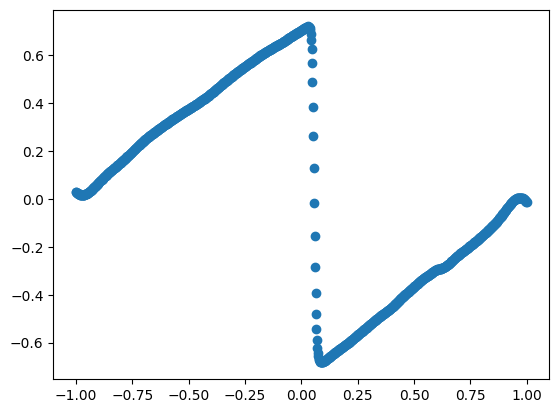

In [39]:
testLen = 1000

TTestVal = 1
TTest = torch.tensor([TTestVal for _ in range(testLen)]).unsqueeze(dim=1)
XTest = torch.linspace(-1, 1, steps=testLen).unsqueeze(dim=1)
XTTest = torch.cat([XTest, TTest], dim=1)

UPredTest = quantized_model.forward(XTTest)

plt.scatter(XTest.detach(), UPredTest.detach())